### Importation des bibliothèques

In [89]:
# ===============================
# 1. IMPORTS
# ===============================
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    roc_curve
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

### Chargement du jeu de données

In [90]:
# ===============================
# 2. CHARGEMENT DES DONNÉES
# ===============================
df = pd.read_csv("../data/transactions.csv")
print("Aperçu des données :")
print(df.head(), "\n")
print("Répartition de la cible (is_fraud) :")
print(df["is_fraud"].value_counts())
print("-" * 50)

Aperçu des données :
  transaction_id            timestamp  amount merchant_id customer_id  \
0       T0000001  2024-03-18 02:07:41  158.01       M0209       C0709   
1       T0000002  2019-11-26 14:39:56  190.25       M0350       C0739   
2       T0000003  2023-11-11 00:18:50  149.89       M0102       C0068   
3       T0000004  2021-05-15 07:44:34    6.97       M0053       C0983   
4       T0000005  2019-04-01 10:20:14   82.24       M0049       C0738   

  transaction_type country device_id   ip_address merchant_category  \
0      prélèvement      UA     D2615  10.0.76.202            banque   
1      prélèvement      UA     D1288  10.0.33.101        restaurant   
2         virement      FR     D1975   10.0.20.97       technologie   
3      prélèvement      JP     D3531  10.0.67.216             santé   
4         virement      ES     D3633   10.0.75.36            loisir   

   hour_of_day  is_fraud  
0            2         1  
1           14         0  
2            0         0  
3    

### Analyse de la variable cible

In [91]:
# ===============================
# 3. FEATURE ENGINEERING
# ===============================
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour_of_day"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek

HIGH_RISK_COUNTRIES = ['RU', 'CN', 'NG', 'UA', 'BR']
df["country_risk"] = df["country"].apply(lambda x: 1 if x in HIGH_RISK_COUNTRIES else 0)

transaction_type_map = {t: i for i, t in enumerate(df["transaction_type"].unique())}
df["transaction_type_encoded"] = df["transaction_type"].map(transaction_type_map)

merchant_category_map = {c: i for i, c in enumerate(df["merchant_category"].unique())}
df["merchant_category_encoded"] = df["merchant_category"].map(merchant_category_map)

FEATURES = [
    "amount",
    "hour_of_day",
    "day_of_week",
    "country_risk",
    "transaction_type_encoded",
    "merchant_category_encoded"
]

X = df[FEATURES]
y = df["is_fraud"]

print("Features utilisées :", FEATURES)
print("-" * 50)

Features utilisées : ['amount', 'hour_of_day', 'day_of_week', 'country_risk', 'transaction_type_encoded', 'merchant_category_encoded']
--------------------------------------------------


### Transformation des variables temporelles

In [92]:
# ===============================
# 4. SCALING
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "../models/scaler.pkl")

['scaler.pkl']

### Création d’un indicateur de risque pays

In [93]:
# ===============================
# 5. TRAIN / TEST SPLIT
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Encodage des variables catégorielles

In [94]:
# ===============================
# 6. GESTION DU DÉSÉQUILIBRE
# ===============================
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Après SMOTE :", np.bincount(y_train_resampled))
print("-" * 50)

Après SMOTE : [7068 7068]
--------------------------------------------------


### Sélection des variables explicatives et cible

In [95]:
# ===============================
# 7. MODÈLE XGBOOST
# ===============================
model = XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    eval_metric="logloss"
)
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Sélection des features et target

In [96]:
# ===============================
# 8. ÉVALUATION
# ===============================
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nRAPPORT DE CLASSIFICATION")
print(classification_report(y_test, y_pred))
print(f"Accuracy (taux de réussite) : {accuracy * 100:.2f} %")
print(f"ROC-AUC : {roc_auc:.4f}")


RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1767
           1       0.65      0.99      0.78       233

    accuracy                           0.94      2000
   macro avg       0.82      0.96      0.87      2000
weighted avg       0.96      0.94      0.94      2000

Accuracy (taux de réussite) : 93.65 %
ROC-AUC : 0.9676


### Normalisation des données

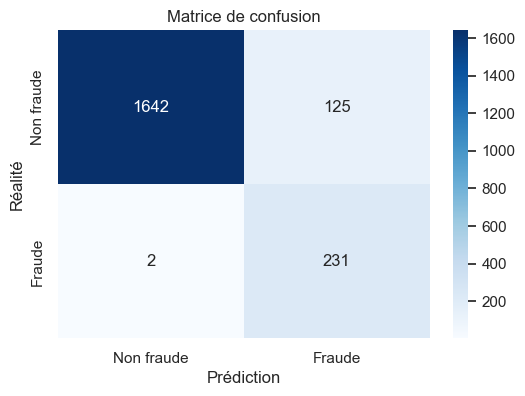

In [97]:
# ===============================
# 9. MATRICE DE CONFUSION
# ===============================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non fraude", "Fraude"],
            yticklabels=["Non fraude", "Fraude"])
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion")
plt.show()

### Séparation Train / Test

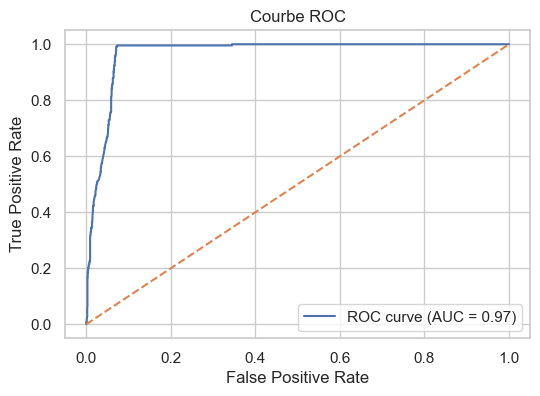

In [98]:
# ===============================
# 10. COURBE ROC
# ===============================
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend()
plt.show()


### Gestion du déséquilibre des classes (SMOTE)

In [99]:
# ===============================
# 11. SAUVEGARDE DU MODÈLE
# ===============================
joblib.dump(model, "../xgboost/fraud_xgboost_model.h5")
print("\n✅ Modèle et scaler sauvegardés avec succès")



✅ Modèle et scaler sauvegardés avec succès
